In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
from sqlalchemy import create_engine

In [5]:
# Uncomment these lines and change directories to write to hdf instead

# dbname = '/Users/rbiswas/data/LSST/OpSimData/kraken_1042_sqlite.db'#enigma_1189_sqlite.db'
# engine = create_engine('sqlite:///' + dbname)
# Summary = pd.read_sql_table('Summary', engine, index_col='obsHistID')
# Summary.to_hdf('/Users/rbiswas/data/LSST/OpSimData/kraken_1042.hdf', 'table')

In [6]:
df = pd.read_hdf('/Users/rbiswas/data/LSST/OpSimData/kraken_1042.hdf', 'table')

In [7]:
df = df.query('fieldID==1427 and propID == 152')

In [8]:
print(df.expMJD.min())
print((df.expMJD.max() + df.expMJD.min()) / 2.)

59580.125716
61401.1227295


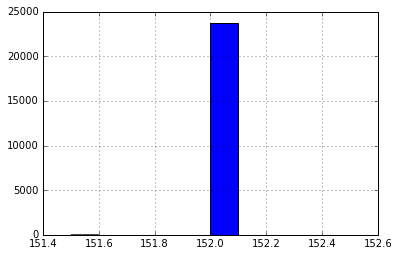

In [9]:
df.propID.hist()

In [10]:
import OpSimSummary.summarize_opsim as so

In [11]:
ds  = so.SummaryOpsim(summarydf=df)

In [12]:
(df.expMJD.max() + df.expMJD.min()) / 2.

61401.122729499999

If I forget dithers and just look at how many observations per field: 
- Look at the number of unique nights with different bands:  For the full survey this number of visits is 1680, see  figure in Input 13
- For half of the survey, the same quantity is 824, see figure 1nput 14
- For a year the number is ~150. See figure on input 15 

In [13]:
full_survey = ds.cadence_plot(fieldID=1427, mjd_center=61404, mjd_range=[-1825, 1825], 
                              observedOnly=False, colorbar=True);
plt.close()

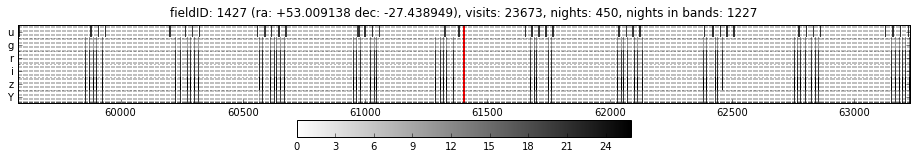

In [14]:
full_survey[0]

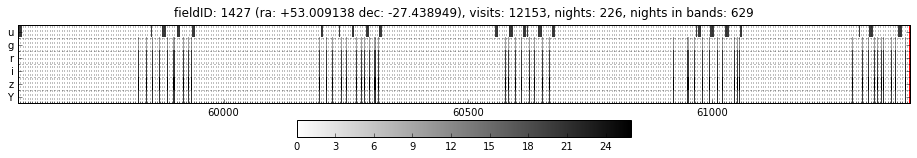

In [15]:
half_survey = ds.cadence_plot(fieldID=1427, mjd_center=61404, mjd_range=[-1825, 1], 
                              observedOnly=False, colorbar=True);


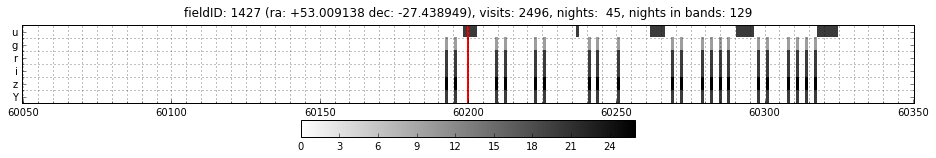

In [16]:
second_year = ds.cadence_plot(fieldID=1427, mjd_center=60200, mjd_range=[-150, 150], 
                              observedOnly=False, colorbar=True);

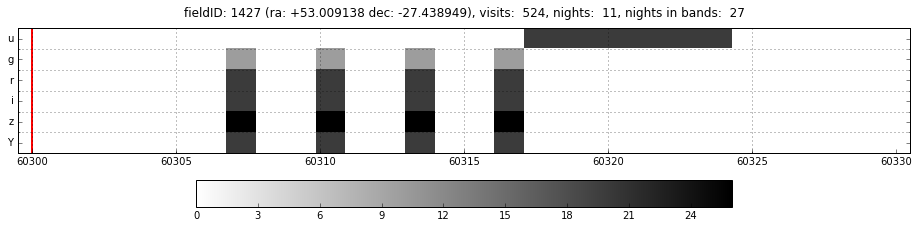

In [17]:
secondYearObs = ds.cadence_plot(fieldID=1427, mjd_center=60300, mjd_range=[-0, 30], observedOnly=False)
plt.close()
secondYearObs[0]

##  List of obsHistIDs with unique nights

#### Proposal :

1. We want to select all the unique night and band combinations in the 10 years of Kraken. As we have seen above this is 1680 visits. 
2. We will give the phosim instance catalogs and seds for running phosim on the cluster, and we should run these in order of expMJD or night. If we run out of compute time at a 1000, then we will have a little more than half of the survey
3. When we get more (phoSim) simulation time, we can finish the 10 years. If we have more time than than, I suggest we **fill in other observations in the 2nd year** as shown in the above figure around 60300. This is another 500 observations. After than we can fill in the rest of the second year and then other years. The priority for the the second year (and could have been elsewhere) is because I can make sure that there a few supernovae that are at high redshift and 'visible' at that time. I need to know this ahead of time, and that is why I putting this out now.

In [18]:
df['obsID'] = df.index.values

In [19]:
uniqueObs = df.groupby(['night', 'filter'])

In [20]:
aa = uniqueObs['airmass'].agg({'myInds': lambda x: x.idxmin()}).myInds.astype(int).values

In [21]:
ourOpSim = df.ix[aa]

####  How much does it help our airmass distribution by choosing the lowest airmass of the available ones

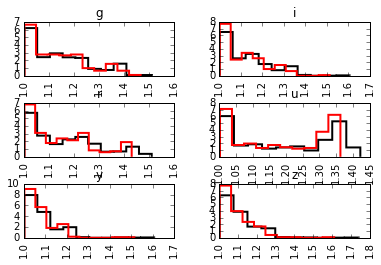

In [22]:
axs = df.hist(by='filter', column='airmass', histtype='step', lw=2, alpha=1, color='k', normed=True);
axs = df.ix[aa].hist(by='filter', column='airmass', histtype='step', lw=2, alpha=1, color='r', ax=axs, normed=True)

In [23]:
df.obsID.unique().size, df.obsID.size

(23673, 23673)

In [24]:
ourOpSim.head()

,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,visitTime,...,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec,obsID
obsHistID,,,,,,,,,,,,,,,,,,,,,
220,1042,152,1427,0.925184,-0.4789,g,11699,59580.135415,0,34,...,84.048697,0.869226,0,0,0.000000,120,24.357859,0.907976,-0.505351,220
230,1042,152,1427,0.925184,-0.4789,i,12177,59580.140948,0,34,...,84.905894,0.791241,0,0,0.000000,120,23.529519,0.907976,-0.505351,230
200,1042,152,1427,0.925184,-0.4789,r,10861,59580.125716,0,34,...,82.698160,0.744120,0,0,0.837387,140,24.234817,0.907976,-0.505351,200
276,1042,152,1427,0.925184,-0.4789,y,14069,59580.162846,0,34,...,89.102576,1.132846,0,0,0.000000,120,21.187902,0.907976,-0.505351,276
250,1042,152,1427,0.925184,-0.4789,z,13015,59580.150647,0,34,...,86.600272,0.928894,0,0,0.000000,120,22.841986,0.907976,-0.505351,250


Our culled opsim that we shall try out first is now 'ourOpSim' . We can write this our to a csv file, or a database. We can also view the list of obsHistIDs

In [25]:
ourOpSim.obsID.values

array([    220,     230,     200, ..., 2442742, 2442799, 2442775])

In [34]:
ourOpSim.obsID.to_csv('FirstSet_obsHistIDs.csv')

In [35]:
ourOpSim.to_csv('SelectedKrakenVisits.csv')

In [26]:
xx = ourOpSim.groupby(['night', 'filter']).aggregate('count')

In [33]:
assert(all(xx.max() == 1))

# Scratch

###  Find the obsHistIDs corresponding to the lowest airmass of visits

In [ ]:
dff = uniqueObs['airmass'].agg({'myInds': lambda x: x.idxmin()})
aa = dff.myInds.astype(int).values
aa.sort()

In [ ]:
l = []
for key in keys:
    l.append(uniqueObs.get_group(key).airmass.idxmin())